In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from IPython.display import display

import os
from data_preprocessing import FilteringCurves, ShowResponseCurves
from fitting_curves import FittingColumn, ShowResponseCurvesWithFitting, compute_r2_score
_FOLDER = "./data/"

In [2]:
def FittedData(df, x_columns, y_columns, fitting_function, parameters_guess=[], default_param = True):
    
    r2, fit_param = FittingColumn(df, df.index, x_columns, y_columns, fitting_function, default_param = True)
    df["fitting_r2"] = r2
    df["fitting_param"] = fit_param
    df= df[df["fitting_r2"]!=0]
    return df

def TransposeCellFeatures(df, indexes_first_column = True):
    # columns in cell_features correspond to drug_curves["COSMIC_ID"] == cell line id
    if indexes_first_column:
        df_transfromed = pd.DataFrame(data= df[df.columns[1:]].values.T,
                          index= df.columns[1:], columns= df[df.columns[0]].values)
    else:
        print("The logic of this function is not applicable")
        
    return df_transfromed 

def PrepareDrugMerge(df):
    """Column fitting_param is splitted into separate columns """
    conc_columns= ["fd_num_"+str(i) for i in range(10)]
    response_norm = ['norm_cells_'+str(i) for i in range(10)]
    param_cols = ["DRUG_ID"] + conc_columns + response_norm
    for i in range(len(df['fitting_param'].values[0])):
        param_col = "param_"+str(i+1)
        param_cols.append(param_col)
        df[param_col] = df['fitting_param'].apply(lambda x: x[i])
    param_cols.insert(0, "COSMIC_ID")
    return df[param_cols]
    

def MergeDrugCells(df_drugs, df_cells):
    cell_features_T = TransposeCellFeatures(df_cells)
    cell_features_T.index = np.array(cell_features_T.index, dtype = "int")
    
    # Not all the drugs from filtered dataset are present in cell lines features
    common_cells_drug = list(set(np.array(df_cells.columns[1:], dtype="int"))& set(df_drugs["COSMIC_ID"].values))
    
    # print("Number of drugs in filtered dataset:", df_328["COSMIC_ID"].nunique())
    # print("Number of common drugs in both datasets", len(common_cells_drug328))

    cell_lines = cell_features_T.loc[common_cells_drug, :].reset_index()
    cell_lines.rename(columns = {"index": "COSMIC_ID"}, inplace=True)
    
    df_drug_param = PrepareDrugMerge(df_drugs)
    
    return pd.merge(left=df_drug_param, right = cell_lines, on = "COSMIC_ID") 

In [3]:
def LeaveOneOutError(kernel_model, X, y, metrics = "mse"):
    errors = []
    splitter_loo = LeaveOneOut()
#     print(splitter_loo.get_n_splits(X))
    
    for train_index, test_index in splitter_loo.split(X):
        X_train_loo, X_test_loo = X[train_index, :], X[test_index,:]
        y_train_loo, y_test_loo = y[train_index], y[test_index]
        
        model = kernel_model.fit(X_train_loo, y_train_loo)
        if metrics == "mse":
            mse = mean_squared_error(y_test_loo, model.predict(X_test_loo))
            errors.append(mse)
        elif metrics == "mae":
            mae = mean_absolute_error(y_test_loo, model.predict(X_test_loo))
            errors.append(mae)
    
    return (sum(errors)/ len(errors)) 

# gamma for RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels

def RunCrossValidation(drug_ids, number_coefficients, kernel='linear', param_tested = "alpha", 
                       param_tested_values = [], alpha=1, gamma=None, degree=3, coef0=1,
                      display_results=True):
    
    df_errors = pd.DataFrame()
    #check whether each coefficient needs its own parameters
    

    for drug_id in drug_ids:
        merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
        # merged_df_i has lower shape
        np.random.seed(123)
        indexes = np.random.permutation(merged_df_i.index)
        train_size = int(merged_df_i.shape[0]*0.8)
        indexes_train = indexes[:train_size]
        X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    
        for i in range(number_coefficients):
            #check whether each coefficient needs its own parameters
            if type(alpha)==dict:
                alpha_value = alpha[i+1]
            else:
                alpha_value = alpha
                
            if type(gamma)==dict:
                gamma_value = gamma[i+1]
            else:
                gamma_value = gamma
            
            if type(degree)==dict:
                degree_value = degree[i+1]
            else:
                degree_value = degree
                
            if type(coef0)==dict:
                coef0_value = coef0[i+1]
            else:
                coef0_value = coef0
            
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)].values
            for param in param_tested_values:
    
                #check whether each coefficient needs its own parameters
                if param_tested == "alpha":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=param, 
                                               gamma=gamma_value, 
                                               degree=degree_value, 
                                               coef0=coef0_value)
                elif param_tested == "gamma":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=alpha_value, 
                                               gamma=param, 
                                               degree=degree_value,
                                               coef0=coef0_value)
                elif param_tested == "degree":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=alpha_value, 
                                               gamma=gamma_value,
                                               degree=param, 
                                               coef0=coef0_value)
                elif param_tested == "coef0":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=alpha_value,  
                                               gamma=gamma_value,
                                               degree=degree_value,
                                               coef0=param)
                else:
                    print("ERROR: Unknown parameters")
                
                # mse is more sensitive to different parameters choice
                mse = LeaveOneOutError(kernel_model, X_train, y_train, metrics="mse")
                df_errors.loc[drug_id, "mse_coef"+str(i+1)+"_"+str(param)] = mse
        
    print("Tuning hyperparameter %s" % param_tested)
    print("x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b \n")
    best_values = {}
    for coef in range(number_coefficients):
#         print("Results for coefficient:", coef+1)
        df_results = df_errors[["mse_coef"+str(coef+1)+"_"+str(param) for param in param_tested_values]].describe().loc[["mean", "min","max"], :]
        best_param = np.float32(df_results.loc["mean",:].idxmin().split("_")[-1])
        best_values[coef+1] = best_param
        if display_results:
            display(df_results)
            print("Coefficient %d: ,  Best %s: %.5f" % (coef+1, param_tested, best_param))
        
    del df_errors
    print("%s kernel, best values for parameter: %s" % (kernel, param_tested))
    print(best_values)
    return best_values

def TestTunedKernels(drug_ids, number_coefficients, kernel, alpha=1, gamma=None, degree=3, coef0=1, 
                     metrics = "mse", display_results=True):
    """Training and testing Kernels with the best found hyperparameters"""
    
    df_errors_test = pd.DataFrame()

    for drug_id in drug_ids:
        # merged_df_i has lower shape
        merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
        
        np.random.seed(123)
        indexes = np.random.permutation(merged_df_i.index)
        train_size = int(merged_df_i.shape[0]*0.8)
        indexes_train = indexes[:train_size]
        indexes_test= indexes[train_size:]
        X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
        X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    
        for i in range(number_coefficients):
#             param = best_param[i+1]
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)].values
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)].values
            
            #check whether each coefficient needs its own parameters
            if type(alpha)==dict:
                alpha_value = alpha[i+1]
            else:
                alpha_value = alpha
                
            if type(gamma)==dict:
                gamma_value = gamma[i+1]
            else:
                gamma_value = gamma
            
            if type(degree)==dict:
                degree_value = degree[i+1]
            else:
                degree_value = degree
                
            if type(coef0)==dict:
                coef0_value = coef0[i+1]
            else:
                coef0_value = coef0
                
            kr_lin = KernelRidge(kernel = kernel, alpha = alpha_value, gamma=gamma_value, 
                                 degree=degree_value, coef0=coef0_value)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            
            # mse is more sensitive to different parameters choice
            if metrics == "mse":
                error = mean_squared_error(y_test, y_pred)
            elif metrics == "mae":
                error = mean_absolute_error(y_test, y_pred)
            else:
                print("ERROR: Unknown metrics")
            df_errors_test.loc[drug_id, kernel+"_mse_coef"+str(i+1)] = error
    
    df_results = df_errors_test.describe().loc[["mean", "min","max"], :]
    if display_results:
        print("Testing %s kernel with tuned hyperparameters\n" % kernel)
        print("Coefficients x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b") 
        display(df_results)
    return df_results

### normalised_dose_response_data.csv

In [4]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
drug_curves.shape

(225384, 44)

In [5]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

df = FilteringCurves(drug_curves, response_norm, 
                     filtering_scenario =[2,3],
                     first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (32974, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (7947, 46)


In [6]:
fitting_function = "sigmoid_4_param"
df = FittedData(df, x_columns=conc_columns, y_columns= response_norm, 
                fitting_function=fitting_function, default_param=True)
print("Fitted data with removed unfit", df.shape)

100%|██████████| 7947/7947 [00:28<00:00, 281.26it/s]


Fitted data with removed unfit (7931, 48)


Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


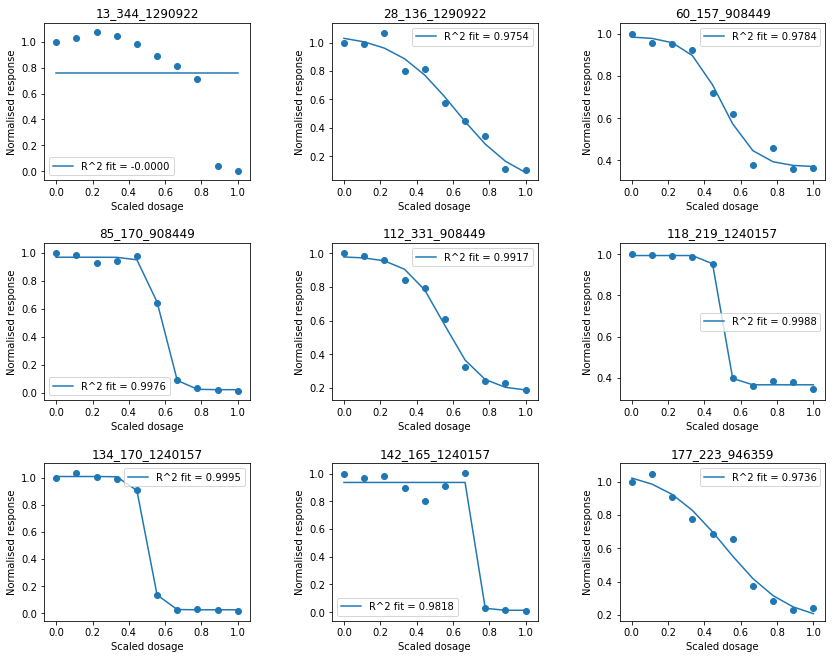

In [7]:
fitting_function = "sigmoid_4_param"
fit_columns = "fitting_param"

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                              y_columns = response_norm, indexes=df.index[:9], 
                              fitting_function = fitting_function, fitting_parameters = fit_columns)

In [8]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
merged_df = MergeDrugCells(df, cell_features)

In [9]:
stat_data = df.groupby(["DRUG_ID"])[["DRUGID_COSMICID"]].count().rename(columns={"DRUGID_COSMICID": "count_cell_lines"})\
            .sort_values("count_cell_lines", ascending=False)
    

drug_features = pd.read_csv(_FOLDER+'/Drug_Features.csv').rename(columns = {"Drug ID": "DRUG_ID"})
statistics = pd.merge(left = stat_data, right = drug_features, how= "left", on = "DRUG_ID").sort_values("count_cell_lines", ascending =False)
statistics.head(10)


,DRUG_ID,count_cell_lines,Drug Name,Synonyms,Target,Target Pathway
0,170,294,Shikonin,Anchusin,not defined,Other
1,276,284,CAY10603,-,"HDAC1, HDAC6",Chromatin histone acetylation
2,274,254,Belinostat,"PXD101, PXD-101",HDAC1,Chromatin histone acetylation
3,328,234,SNX-2112,SNX 2112,HSP90,Protein stability and degradation
4,200,231,Dacinostat,"NVP-LAQ824, LAQ824",HDAC1,Chromatin histone acetylation
5,272,225,AR-42,"HDAC-42, AR 42, AR42",HDAC1,Chromatin histone acetylation
6,194,208,Luminespib,"AUY922, VER-52296,NVP-AUY922, AUY",HSP90,Protein stability and degradation
7,157,206,JNK-9L,"KIN001-204, JNK inhibitor 9l","JNK2, JNK3",JNK and p38 signaling
8,273,194,CUDC-101,CUDC 101,"HDAC1-10, EGFR, ERBB2",Other
9,219,185,AT-7519,AT7519,"CDK1, CDK2, CDK4, CDK6, CDK9",Cell cycle


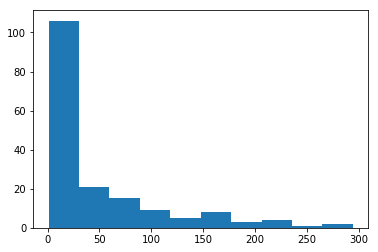

In [10]:
plt.hist(statistics["count_cell_lines"].values);

In [11]:
print("Number of drugs with more than 30 records:", stat_data[stat_data["count_cell_lines"]>50].shape[0])
print("Number of drugs with less than 10 records:", stat_data[stat_data["count_cell_lines"]<10].shape[0])
print("Number of drugs with only 1 record:", stat_data[stat_data["count_cell_lines"]==1].shape[0])

Number of drugs with more than 30 records: 49
Number of drugs with less than 10 records: 70
Number of drugs with only 1 record: 21


In [12]:
statistics[statistics["count_cell_lines"]==1]

,DRUG_ID,count_cell_lines,Drug Name,Synonyms,Target,Target Pathway
168,255,1,CP724714,CP-724714,ERBB2,EGFR signaling
165,197,1,Bryostatin 1,Bryostatin,PKC,"Other, kinases"
166,345,1,KIN001-270,"CDK9 inhibitor, CDK9-IN-1",CDK9,Cell cycle
167,238,1,Idelalisib,"CAL-101, Zydelig",PI3Kdelta,PI3K/MTOR signaling
172,294,1,MPS-1-IN-1,-,MPS1,Mitosis
169,266,1,Zibotentan,"ZD4054, ZD-4054",Endothelin-1 receptor (EDNRA),Other
170,286,1,KIN001-236,-,Angiopoietin-1 receptor,Other
171,290,1,KIN001-260,"Bayer IKKb inhibitor, ACHP",IKKB,Other
163,147,1,NSC-87877,NSC 87877,"SHP-1 (PTPN6), SHP-2 (PTPN11)",Other
164,156,1,AZD6482,"AZD 6482, AZD-6482, AK-55409",PI3Kbeta,PI3K/MTOR signaling


### Linear kernel

In [13]:
gr = df.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
drug_ids = list(gr[gr > 50].index)

In [14]:
%%time
best_linear_alpha = RunCrossValidation(drug_ids, 4, kernel='linear', param_tested = "alpha", 
                       param_tested_values = [0.1, 0.5, 1, 5, 7], display_results=False)

print("")

best_linear_alpha = RunCrossValidation(drug_ids, 4, kernel='linear', param_tested = "alpha", 
                       param_tested_values = [7, 10, 30, 50, 100], display_results=False)
print("")

best_linear_alpha = RunCrossValidation(drug_ids, 4, kernel='linear', param_tested = "alpha", 
                       param_tested_values = [50, 100, 200, 300, 500], display_results=False)
print("")

Tuning hyperparameter alpha
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

linear kernel, best values for parameter: alpha
{1: 7.0, 2: 7.0, 3: 7.0, 4: 7.0}

Tuning hyperparameter alpha
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

linear kernel, best values for parameter: alpha
{1: 100.0, 2: 50.0, 3: 50.0, 4: 100.0}

Tuning hyperparameter alpha
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

linear kernel, best values for parameter: alpha
{1: 100.0, 2: 50.0, 3: 50.0, 4: 100.0}

CPU times: user 32min 24s, sys: 3min 20s, total: 35min 44s
Wall time: 21min 12s


In [15]:
print(best_linear_alpha)

{1: 100.0, 2: 50.0, 3: 50.0, 4: 100.0}


### Sigmoid Kernel

In [16]:
%%time
best_sigmoid_gamma = RunCrossValidation(drug_ids, 4, kernel='sigmoid', param_tested = "gamma", 
                       param_tested_values = [0.01, 0.1, 0.5, 1], display_results=False)
print("")
best_sigmoid_gamma = RunCrossValidation(drug_ids, 4, kernel='sigmoid', param_tested = "gamma", 
                       param_tested_values = [0.00001, 0.0001, 0.01], display_results=False)
print("")

best_sigmoid_alpha= RunCrossValidation(drug_ids, 4, kernel='sigmoid', gamma= best_sigmoid_gamma, 
                                       param_tested = "alpha", 
                                       param_tested_values = [0.01, 0.1, 0.5, 1, 5], display_results=False)
print("")


best_sigmoid_coef0 = RunCrossValidation(drug_ids, 4, kernel='sigmoid', gamma= best_sigmoid_gamma, 
                                        param_tested = "coef0", alpha=best_sigmoid_alpha,
                                        param_tested_values = [-0.1, 0, 0.1, 0.5, 1], display_results=False)

print("")
best_sigmoid_coef0 = RunCrossValidation(drug_ids, 4, kernel='sigmoid', gamma= best_sigmoid_gamma, 
                                       param_tested = "coef0", alpha=best_sigmoid_alpha,
                                       param_tested_values = [0, 1, 5, 10], display_results=False)

Tuning hyperparameter gamma
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

sigmoid kernel, best values for parameter: gamma
{1: 0.01, 2: 0.01, 3: 0.01, 4: 0.01}

Tuning hyperparameter gamma
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

sigmoid kernel, best values for parameter: gamma
{1: 1e-05, 2: 1e-04, 3: 0.01, 4: 1e-04}

Tuning hyperparameter alpha
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

sigmoid kernel, best values for parameter: alpha
{1: 1.0, 2: 0.5, 3: 1.0, 4: 1.0}

Tuning hyperparameter coef0
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

sigmoid kernel, best values for parameter: coef0
{1: 0.5, 2: 0.5, 3: 1.0, 4: 0.5}

Tuning hyperparameter coef0
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

sigmoid kernel, best values for parameter: coef0
{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
CPU times: user 54min 36s, sys: 5min 14s, total: 59min 50s
Wall time: 1h 17min 36s


In [17]:
print(best_sigmoid_coef0)
print(best_sigmoid_gamma)
print(best_sigmoid_alpha)

sigmod_kernel = {"coef0": {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
                 "gamma": {1: 1e-05, 2: 1e-04, 3: 0.01, 4: 1e-04},
                 "alpha"{1: 1.0, 2: 0.5, 3: 1.0, 4: 1.0}}

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
{1: 1e-05, 2: 1e-04, 3: 0.01, 4: 1e-04}
{1: 1.0, 2: 0.5, 3: 1.0, 4: 1.0}


### RBF kernel

In [18]:
%%time
best_rbf_gamma = RunCrossValidation(drug_ids, 4, kernel='rbf', param_tested = "gamma", alpha=1,
                       param_tested_values = [0.00001, 0.0001, 0.001, 0.1, 1], display_results=False)

print("")

best_rbf_alpha= RunCrossValidation(drug_ids, 4, kernel='rbf', param_tested = "alpha", gamma=best_rbf_gamma,
                       param_tested_values = [0.01, 0.1, 1, 5, 10], display_results=False)
print("")

Tuning hyperparameter gamma
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

rbf kernel, best values for parameter: gamma
{1: 1e-05, 2: 1e-04, 3: 0.001, 4: 1e-04}

Tuning hyperparameter alpha
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

rbf kernel, best values for parameter: alpha
{1: 1.0, 2: 1.0, 3: 1.0, 4: 5.0}

CPU times: user 25min 59s, sys: 2min 30s, total: 28min 30s
Wall time: 39min 55s


In [19]:
# best_rbf_alpha_rbf = {1:5, 2:1, 3:0.01, 4:10}
# best_rbf_gamma_rbf= 0.00001
print(best_rbf_alpha)
print(best_rbf_gamma)

{1: 1.0, 2: 1.0, 3: 1.0, 4: 5.0}
{1: 1e-05, 2: 1e-04, 3: 0.001, 4: 1e-04}


### Polynomial Kernel

In [20]:
%%time
best_polynomial_gamma = RunCrossValidation(drug_ids, 4, kernel='polynomial', param_tested = "gamma", 
                       param_tested_values = [0.00001, 0.0001, 0.01, 0.1, 1, 5], display_results=False)
print("")

best_polynomial_degree = RunCrossValidation(drug_ids, 4, kernel='polynomial', param_tested = "degree", gamma= 0.00001,
                       param_tested_values = [1,2,3,4,5], display_results=False)
print("")

best_polynomial_alpha = RunCrossValidation(drug_ids, 4, kernel='polynomial', param_tested = "alpha", gamma= 0.00001,
                       param_tested_values = [0.001, 0.01, 0.1, 1, 5, 7], display_results=False)
print("")


Tuning hyperparameter gamma
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

polynomial kernel, best values for parameter: gamma
{1: 1e-05, 2: 1e-04, 3: 1e-04, 4: 1e-04}

Tuning hyperparameter degree
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

polynomial kernel, best values for parameter: degree
{1: 1.0, 2: 5.0, 3: 5.0, 4: 5.0}

Tuning hyperparameter alpha
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

polynomial kernel, best values for parameter: alpha
{1: 1.0, 2: 1.0, 3: 0.01, 4: 5.0}

CPU times: user 40min 16s, sys: 3min 50s, total: 44min 6s
Wall time: 44min 15s


In [21]:
# best_polynomial_gamma = 0.00001
# best_polynomial_degree= {1: 1.0, 2: 1.0, 3: 5.0, 4: 1.0}
# best_polynomial_alpha = {1: 5, 2:1, 3: 0.01, 4: 7}
print(best_polynomial_gamma)
print(best_polynomial_degree)
print(best_polynomial_alpha)

{1: 1e-05, 2: 1e-04, 3: 1e-04, 4: 1e-04}
{1: 1.0, 2: 5.0, 3: 5.0, 4: 5.0}
{1: 1.0, 2: 1.0, 3: 0.01, 4: 5.0}


### additive_chi2 kernel

In [22]:
%%time
best_additive_chi2_gamma = RunCrossValidation(drug_ids, 4, kernel='additive_chi2', param_tested = "gamma", 
                       param_tested_values = [0.00001, 0.0001, 0.01, 0.1, 1, 5], display_results=False)
print("")
best_additive_chi2_alpha = RunCrossValidation(drug_ids, 4, kernel='additive_chi2', param_tested = "alpha", 
                                              gamma = best_additive_chi2_gamma,
                                              param_tested_values = [0.00001, 0.0001, 0.01, 0.1, 1, 5], 
                                              display_results=False)
print("")

Tuning hyperparameter gamma
x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b 

additive_chi2 kernel, best values for parameter: gamma
{1: 1e-05, 2: 1e-05, 3: 1e-05, 4: 1e-05}



KeyboardInterrupt: 

### laplacian kernel

In [ ]:
%%time
best_laplacian_gamma = RunCrossValidation(drug_ids, 4, kernel='laplacian', param_tested = "gamma", 
                       param_tested_values = [0.00001, 0.0001, 0.01, 0.1, 1, 5],
                                          display_results=False)
print("")
best_laplacian_alpha = RunCrossValidation(drug_ids, 4, kernel='laplacian', param_tested = "alpha", 
                                              gamma = best_laplacian_gamma,
                                              param_tested_values = [0.00001, 0.0001, 0.01, 0.1, 1, 5],
                                              display_results=False)
print("")

### Training and testing Kernels with best parameter

In [ ]:
tests={}

# linear kernel
tests["linear"] = TestTunedKernels(drug_ids, 4, kernel='linear', alpha=best_linear_alpha, 
                 gamma=None, degree=3, coef0=1, metrics = "mse", display_results=False)

# sigmoid kernel
tests["sigmoid"] = TestTunedKernels(drug_ids, 4, kernel='sigmoid', alpha=best_sigmoid_alpha, 
                 gamma= best_sigmoid_gamma, coef0= best_sigmoid_coef0,
                 degree=1, metrics = "mse", display_results=False)

# rbf kernel:

tests['rbf'] = TestTunedKernels(drug_ids, 4, kernel='rbf', alpha=best_rbf_alpha, gamma= best_rbf_gamma, 
                 degree=3, metrics = "mse", display_results=False)

# polynomial kernel:

tests['polynomial'] = TestTunedKernels(drug_ids, 4, kernel='polynomial', alpha=best_rbf_alpha, gamma= best_polynomial_gamma, 
                 degree=1, metrics = "mse", display_results=False)

# additive_chi2 kernel:

tests['additive_chi2'] = TestTunedKernels(drug_ids, 4, kernel='additive_chi2', alpha=best_additive_chi2_alpha, 
                 gamma= best_additive_chi2_gamma, 
                 degree=1, metrics = "mse", display_results=False)

# laplacian kernel:
df = TestTunedKernels(drug_ids, 4, kernel='laplacian', alpha=best_laplacian_alpha, 
                 gamma= best_laplacian_gamma, 
                 degree=1, metrics = "mse", display_results=False)
tests['laplacian'] = df

kernels = ["linear", "sigmoid", "rbf", "polynomial","additive_chi2","laplacian"]
best_kernels = {}
for i in range(4):
    test_kernels_comparison = pd.DataFrame(index=["mean", "min", "max"])
    
    for kernel in kernels:
        test_kernels_comparison[kernel] = tests[kernel][tests[kernel].columns[i]]
    display(test_kernels_comparison)
    best_kernels[i+1]= test_kernels_comparison.loc["mean", :].idxmin(axis=1)
    print("Coefficient: %d, best kernel: %s" % (i+1, best_kernels[i+1]))
best_kernels

In [ ]:
best_kernels